In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,MultiHeadAttention,Flatten,Reshape
import matplotlib.pyplot as plt

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data_dir = ''
test_data_dir = ''
val_data_dir = ''

img_width, img_height = 224, 224
batch_size = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9650 images belonging to 22 classes.
Found 1802 images belonging to 22 classes.
Found 1814 images belonging to 22 classes.


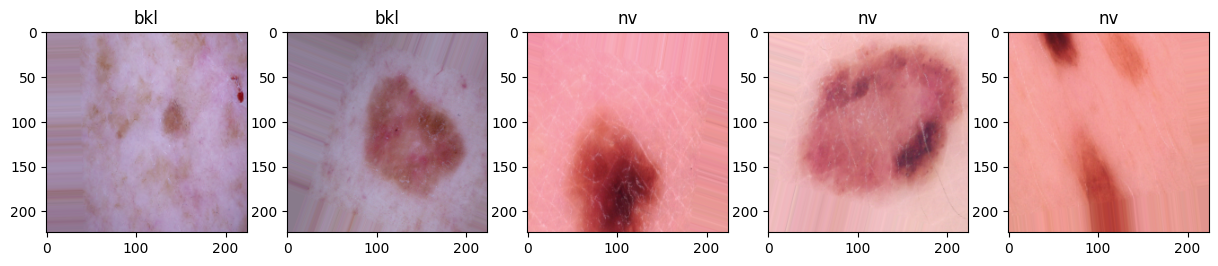

In [6]:
images,labels = train_generator.next()
class_names = list(train_generator.class_indices.keys())
display=5

plt.figure(figsize=(15,5))

for i in range(display):
    plt.subplot(1,display,i+1)
    plt.imshow(images[i])
    class_ind=labels[i].argmax()
    class_name=class_names[class_ind]
    plt.title(class_name)
plt.show()

In [7]:
base_model=MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
mha = MultiHeadAttention(num_heads=12, key_dim=2)
query_reshape = Reshape((1, -1, 1280))
value_reshape = Reshape((1, -1, 1280))
query = query_reshape(x)
value = value_reshape(x)
x = mha(query,value)
x = Dense(1024, activation='relu')(x)
x = Flatten()(x)

predictions = Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/100
161/301 [===============>..............] - ETA: 24:32 - loss: 1.4482 - accuracy: 0.5522

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
saved_model_loc = 'Ham_mobilenet.keras'

In [ ]:
model.save(saved_model_loc)

In [ ]:
model = tf.keras.models.load_model(saved_model_loc)
model.summary()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
tflite_model_path = 'Ham_mobilenet.tflite'
tf.io.write_file(tflite_model_path,tflite_model)

In [ ]:
'''
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")

# Plot training history (optional)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()
'''

In [ ]:
'''
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

img_path = 'path_to_input_image.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)

img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
'''